## Pendulum: One-pfive step Method

In [1]:
import sys
#sys.path.append('/Users/josorior/Documents/UW/research/keql/KEQL/source')
#sys.path.append('/Users/yasaminjalalian/Repos/KEQL/source')
sys.path.append('/home/juanfelipe/Desktop/research/keql/source')

In [2]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt 
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error
from parameter_learning import *
from plotlib import *
from models import * 
from kernels import *
from data_loader import *
from loss import *
from utils import *

import jax
import jax.numpy as jnp
from jax import grad, jit
from jax.scipy.optimize import minimize
from jax.config import config; 
config.update("jax_enable_x64", True)

from functools import partial # for jit to make codes faster

TypeError: ODE_solutions() missing 4 required positional arguments: 'M1', 'M2', 'M3', and 'e'

In [3]:
model = 'pendulum'

In [4]:
M

array([False, False, False,  True, False,  True, False, False,  True,
        True, False, False,  True,  True,  True,  True,  True,  True,
       False, False, False, False, False,  True,  True, False,  True,
       False,  True, False])

### Small experiment

Numpy slicing is fine with a boolean array `M`

In [4]:
np.random.seed(1)
Z = np.arange(1,36).reshape(7,5)
U = -np.arange(1,36).reshape(7,5)
M = np.random.randint(2, size=35).reshape(7,5)
M = np.array(M, dtype=bool)
print('M:',M)
Z[M] = U[M]
Z 

M: [[ True  True False False  True]
 [ True  True  True  True False]
 [False  True False  True  True]
 [False False  True False False]
 [False  True False False  True]
 [False False False  True False]
 [False False  True  True  True]]


array([[ -1,  -2,   3,   4,  -5],
       [ -6,  -7,  -8,  -9,  10],
       [ 11, -12,  13, -14, -15],
       [ 16,  17, -18,  19,  20],
       [ 21, -22,  23,  24, -25],
       [ 26,  27,  28, -29,  30],
       [ 31,  32, -33, -34, -35]])

If we now want to use `JAX` combined with `numpy` to optimize 

In [5]:
def myfun(Z):
    M = np.array([0,1,1]) # use np
    M = np.array(M, dtype=bool) # use np
    U = np.array([10.,2.,3.]) # use np
    Z = Z.at[M].set(U[M]) 
    return (Z[0] - 4)**2 + Z[1]**2 + Z[2]**2

In order to optimize a function...

In [6]:
Z = jnp.array([3,4,2])
learning_rate = 1e-2
grad_Z = jit(grad(myfun, argnums=0))
# Run once to trigger JIT compilation.
grad_Z(jnp.array([2.,10.,11.]))
Z = jnp.array([2.,10.,11.])
for i in range(1000):
    delta_Z = grad_Z(Z)
    lr = jnp.linalg.norm(Z)/jnp.linalg.norm(delta_Z)*learning_rate
    Z -= lr * delta_Z
    if i % 10 == 0:
        print(Z)
        print(myfun(Z))

[ 2.15 10.   11.  ]
16.4225
[ 3.66388513 10.         11.        ]
13.112973204840255
[ 3.96886038 10.         11.        ]
13.00096967601397
[ 3.96684054 10.         11.        ]
13.001099549939564
[ 3.96482171 10.         11.        ]
13.00123751242749
[ 3.96280388 10.         11.        ]
13.001383551299659
[ 3.96078706 10.         11.        ]
13.00153765439218
[ 3.95877125 10.         11.        ]
13.001699809555346
[ 3.95675645 10.         11.        ]
13.00187000465362
[ 3.95474265 10.         11.        ]
13.002048227565615
[ 3.95272986 10.         11.        ]
13.002234466184085
[ 3.95071807 10.         11.        ]
13.0024287084159
[ 3.94870729 10.         11.        ]
13.002630942182048
[ 3.94669751 10.         11.        ]
13.002841155417597
[ 3.94468873 10.         11.        ]
13.003059336071704
[ 3.94268096 10.         11.        ]
13.00328547210758
[ 3.94067419 10.         11.        ]
13.003519551502485
[ 3.93866842 10.         11.        ]
13.003761562247718
[ 3.936663

### Cost function

Create objective function `L`

In [4]:
def L(Z, X, U, M, f, m, N, lmbd, kernel = Gaussian):
    """Cost function for one step method.
    
    Args:
        Z: Vector [Z^1 Z^2 Z^3]^T. 2*m*N
        X: List of mN points of dimension d.
        U: List of N1+N2+N3 values of functions u^(1),...u^(N).
        M: Bolean array which contains where true values reside.
        f: List of mN values of functions u^(1),...u^(N).
        m: Number of functions
        N: Number of total points per function
        kernel: Kernel function
        R: Matrix that regularizes Kphiphi

    Returns:
        scalar: a cost of this solution.    
    """ 

    ### Set up
    N = 10
    m = 3
    # Constrain the value of Z with known info
    #Z = Z.at[M].set(U[M])  Not supported by jit
    Z = jnp.where(M, U, Z)
     
    # Cd + 1 = 4
    S = jnp.zeros((N*m,4))
    # Split Z
    for i in range(m):
        Zi = Z[i*N:(i+1)*N]
        #optim_sgm , optim_lmbd = grid_search_RBF_JAX(X[:N].reshape(N,1),Zi.reshape(-1,1))
        optim_sgm , optim_lmbd = 0.5, 1e-4
        G = K(kernel, X[:N], X[:N], optim_sgm) 
        alphas = jnp.linalg.solve(G + optim_lmbd*jnp.eye(N),Zi)
        Zi_x = jnp.dot(K_dot(kernel, X[:N], X[:N], optim_sgm, 0), alphas)
        Zi_xx = jnp.dot(K_2dot(kernel, X[:N], X[:N], optim_sgm, 0,0), alphas)
        Si = jnp.vstack((X[:N],Zi, Zi_x,Zi_xx)).T
        S = S.at[i*N:(i+1)*N,:].set(Si)
    # Scaling S_N
    scaler_s_train = MinMaxScaler()
    S = scaler_s_train.fit_transform(S)
    # Gamma(S_N,S_N)
    sigma_Gamma = 1.35 # From 2-step
    Gamma = K(Gaussian, S, S, sigma_Gamma)
    alpha_Gamma = 1.1e-7 # nugget from 2-step !!!
    Gamma = Gamma + alpha_Gamma*jnp.eye(jnp.size(Gamma,0)) 
    #print("cond(Gamma) = ", jnp.linalg.cond(Gamma))

    # (Gamma(S_N,S_N) + alpha_Gamma*I)^-1 * f
    b = jnp.linalg.solve(Gamma,f)

    # First term
    L1 = jnp.dot(f.T , b)

    # # Second term
    sigma_K = jnp.mean(jnp.array([0.24994344, 0.74908123, 0.74908123])) # From 2-step
    K_XN = K(Gaussian,X[:N],X[:N],sigma_K)
    K_XN = K_XN + 1e-5*jnp.eye(N) 
    
    L2 = 0.
    
    for i in range(m):
        Zi = Z[i*N:(i+1)*N]
        c = jnp.linalg.solve(K_XN,Zi)
        L2 += jnp.reshape(jnp.dot(Zi.T , c),())       
    
    return L1 + lmbd*L2
    

#### Gradient descent

Training data

In [5]:
# First column in Gamma(S_N,S_N)
X = x_train_all.flatten() # N*m * 1

# Second column in Gamma(S_N,S_N)
U = u_train.T.reshape(N*m,) # N*m * 1

# f(X_N)
f = f_Train(model)

Initial guess: `Z_warm`

In [6]:
# Load values of U predicted from 2-step
u_pred_train = np.load('data/u_pred_train.npy')
u_x_pred_train = np.load('data/u_x_pred_train.npy')
u_xx_pred_train = np.load('data/u_xx_pred_train.npy')
# Build Z_warm
Z_warm = jnp.array(u_pred_train.T.reshape(N*m,)) 

Here we can start checking:
- Order of `L1(Z_warm)`
- Order of `L2(Z_warm)`
- Condition numbers of `Gamma` and `Kphiphi` 

In [8]:
L(Z_warm, X, U, M, f, m, N, lmbd=1/3)

Array(387253.1212356, dtype=float64)

Initialize the grad functions with `jit` to be efficient

In [9]:
grad_Z = jit(grad(L, argnums=0))

# Run once to trigger JIT compilation.
grad_Z(Z_warm, X, U, M, f, m, N, lmbd=1/3)
# Warm start here !!!

Array([ 3.26384942e+05,  0.00000000e+00, -3.40331894e+05,  0.00000000e+00,
       -9.71176364e+04,  1.05918596e+05,  7.78395253e+05,  0.00000000e+00,
        1.41906678e+04,  0.00000000e+00,  9.12284573e+06, -1.00236718e+07,
        0.00000000e+00,  1.28854918e+07,  6.85941301e+06,  0.00000000e+00,
       -2.60213541e+06,  0.00000000e+00,  0.00000000e+00,  2.70947831e+06,
        5.25020975e+05, -5.03616450e+05,  0.00000000e+00,  1.91614243e+05,
        0.00000000e+00,  1.76402666e+05, -1.24199315e+04,  0.00000000e+00,
        0.00000000e+00,  2.85254392e+05], dtype=float64)

Run the gradient descent for `100` epochs

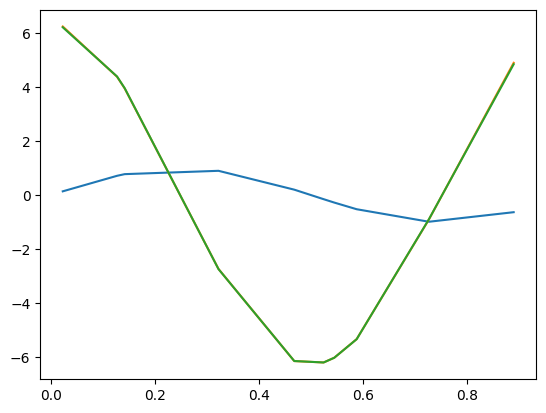

In [10]:
plt.plot(x_train, U[0:N])
plt.plot(x_train, u_x_pred_train[0:N,0])
plt.plot(x_train, u_x_train[:,0])
plt.show()

### Gradient descent

In [11]:
u_t = u_train.T.reshape(N*m,1)
# Load true gradients from 2-step
u_x_train = np.load('data/u_x_train.npy')
u_xx_train = np.load('data/u_xx_train.npy')
# Build true Z
Z_true = np.hstack([u_t, u_x_train.T.reshape(N*m,1),u_xx_train.T.reshape(N*m,1)])

In [14]:
# Only do this for the first time - 
Z = np.copy(Z_warm)
#Z = np.load('data/Z.npy')

In [17]:
mses = []
S = jnp.zeros((N*m,4))
kernel = Gaussian
# If trained previously use Z
if np.all(Z != Z_warm):
    Z = np.load('data/Z.npy')
else:
    Z = np.copy(Z_warm)
learning_rate = 1e-4
for i in range(3000):
    delta_Z = grad_Z(Z, X, U, M, f, m, N, lmbd=1e-7)
    lr = jnp.linalg.norm(Z)/jnp.linalg.norm(delta_Z)*learning_rate
    Z -= lr * delta_Z
    
    # Pred
    for j in range(m):
        Zi = Z[j*N:(j+1)*N]
        #optim_sgm , optim_lmbd = grid_search_RBF_JAX(X[:N].reshape(N,1),Zi.reshape(-1,1))
        optim_sgm , optim_lmbd = 0.5, 1e-4
        G = K(kernel, X[:N], X[:N], optim_sgm) 
        alphas = jnp.linalg.solve(G + optim_lmbd*jnp.eye(N),Zi)
        Zi_x = jnp.dot(K_dot(kernel, X[:N], X[:N], optim_sgm, 0), alphas)
        Zi_xx = jnp.dot(K_2dot(kernel, X[:N], X[:N], optim_sgm, 0,0), alphas)
        Si = jnp.vstack((X[:N],Zi, Zi_x,Zi_xx)).T
        S = S.at[j*N:(j+1)*N,:].set(Si)
    Spred = S[:,-3:]
    mse = mean_squared_error(Spred,Z_true)/mean_squared_error(0*Spred,Z_true)
    mses.append(mse)
    if i % 10 == 0:
        print('iter:', i )
        print('loss: ',L(Z, X, U, M, f, m, N, lmbd=1e-7))
        print('mse:', mse)
    
# Save at the end of iterations
np.save('data/Z.npy',Z)

iter: 0
loss:  344603.83844159386
mse: 0.07064239463185094
iter: 10
loss:  153430.18732355646
mse: 0.07169706866397955
iter: 20
loss:  120244.29499273784
mse: 0.07218972889053459
iter: 30
loss:  78996.3972042224
mse: 0.07311779316984876
iter: 40
loss:  46832.133659992316
mse: 0.07611422688988047
iter: 50
loss:  46245.94761977196
mse: 0.0760375092687484
iter: 60
loss:  45592.302519256926
mse: 0.07581865332223703
iter: 70
loss:  45007.79009572646
mse: 0.0756097643860243
iter: 80
loss:  44476.27835239879
mse: 0.07541861400806515
iter: 90
loss:  43987.6409500046
mse: 0.07524431389264609
iter: 100
loss:  43534.78658928665
mse: 0.07508492491939679
iter: 110
loss:  43112.473147719866
mse: 0.0749387006178477
iter: 120
loss:  42716.67977835741
mse: 0.0748042156019202
iter: 130
loss:  42344.23239478643
mse: 0.07468031190995762
iter: 140
loss:  41992.565500142104
mse: 0.07456603437412825
iter: 150
loss:  41659.56381860971
mse: 0.07446058072719708
iter: 160
loss:  41343.45381374115
mse: 0.07436326

## Evaluation of `Z`

Text(0, 0.5, 'relative mse')

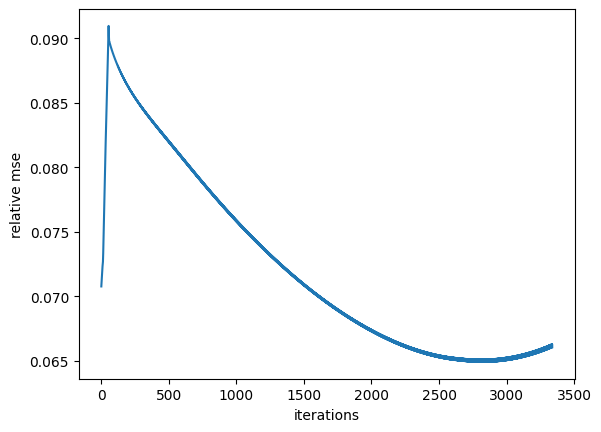

In [66]:
plt.plot(mses)
plt.xlabel('iterations')
plt.ylabel('relative mse')

In [67]:
Ztest = np.load('data/Z.npy')

In [68]:
S = jnp.zeros((N*m,4))
kernel = Gaussian
# Split Z
for i in tqdm(range(m)):
    Zi = Ztest[i*N:(i+1)*N]
    #optim_sgm , optim_lmbd = grid_search_RBF_JAX(X[:N].reshape(N,1),Zi.reshape(-1,1))
    optim_sgm , optim_lmbd = 0.5, 1e-4
    G = K(kernel, X[:N], X[:N], optim_sgm) 
    alphas = jnp.linalg.solve(G + optim_lmbd*jnp.eye(N),Zi)
    Zi_x = jnp.dot(K_dot(kernel, X[:N], X[:N], optim_sgm, 0), alphas)
    Zi_xx = jnp.dot(K_2dot(kernel, X[:N], X[:N], optim_sgm, 0,0), alphas)
    Si = jnp.vstack((X[:N],Zi, Zi_x,Zi_xx)).T
    S = S.at[i*N:(i+1)*N,:].set(Si)

100%|██████████| 3/3 [00:00<00:00,  3.05it/s]


In [69]:
Z15 = S[:,-2:]

In [58]:
Z15.shape

(30, 2)

In [70]:
# Load true gradients from 2-step
u_x_train = np.load('data/u_x_train.npy')
u_xx_train = np.load('data/u_xx_train.npy')
# Build true Z
Z_true = np.hstack([u_x_train.T.reshape(N*m,1),u_xx_train.T.reshape(N*m,1)])

> Onepfive-step Method vs Truth

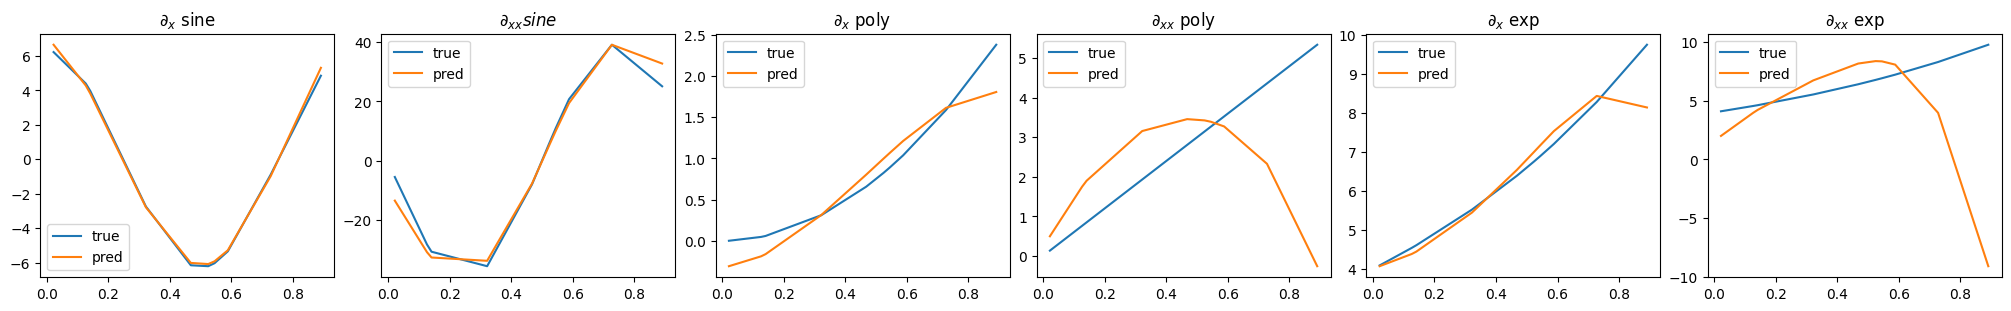

In [71]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows = 1, ncols=6, figsize = (20,3),constrained_layout=True)
ax1.set_title(r'$\partial_x$ sine')
ax1.plot(x_train,Z_true[0:N,0],label ='true')
ax1.plot(x_train,Z15[0:N,0],label ='pred')
ax1.legend()
ax2.set_title(r'$\partial_{xx} sine$')
ax2.plot(x_train,Z_true[0:N,1],label ='true')
ax2.plot(x_train,Z15[0:N,1],label ='pred')
ax2.legend()
ax3.set_title(r'$\partial_x$ poly')
ax3.plot(x_train,Z_true[N:2*N,0],label ='true')
ax3.plot(x_train,Z15[N:2*N,0],label ='pred')
ax3.legend()
ax4.set_title(r'$\partial_{xx}$ poly')
ax4.plot(x_train,Z_true[N:2*N,1],label ='true')
ax4.plot(x_train,Z15[N:2*N,1],label ='pred')
ax4.legend()
ax5.set_title(r'$\partial_x$ exp')
ax5.plot(x_train,Z_true[2*N:3*N,0],label ='true')
ax5.plot(x_train,Z15[2*N:3*N,0],label ='pred')
ax5.legend()
ax6.set_title(r'$\partial_{xx}$ exp')
ax6.plot(x_train,Z_true[2*N:3*N,1],label ='true')
ax6.plot(x_train,Z15[2*N:3*N,1],label ='pred')
ax6.legend()
plt.show()

> Two-step Method vs Truth

In [21]:
# Load gradients from 2-step
u_x_pred_train  = np.load('data/u_x_pred_train.npy')
u_xx_pred_train = np.load('data/u_xx_pred_train.npy')
# Build Z_warm
Z_2step = np.hstack([u_x_pred_train.T.reshape(N*m,1),u_xx_pred_train.T.reshape(N*m,1)])

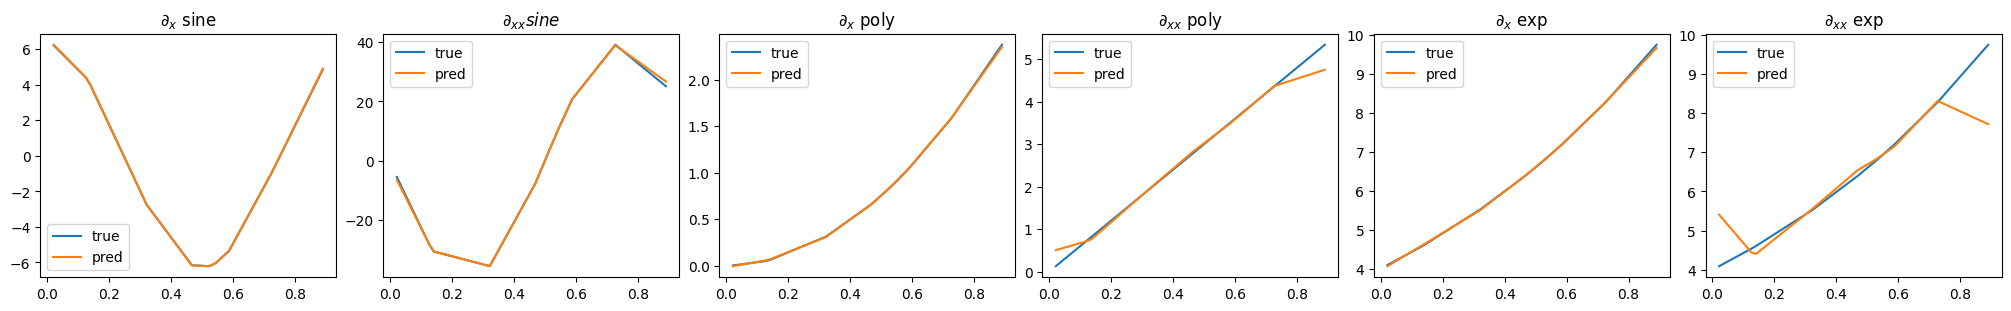

In [22]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows = 1, ncols=6, figsize = (20,3),constrained_layout=True)
ax1.set_title(r'$\partial_x$ sine')
ax1.plot(x_train,Z_true[0:N,0],label ='true')
ax1.plot(x_train,Z_2step[0:N,0],label ='pred')
ax1.legend()
ax2.set_title(r'$\partial_{xx} sine$')
ax2.plot(x_train,Z_true[0:N,1],label ='true')
ax2.plot(x_train,Z_2step[0:N,1],label ='pred')
ax2.legend()
ax3.set_title(r'$\partial_x$ poly')
ax3.plot(x_train,Z_true[N:2*N,0],label ='true')
ax3.plot(x_train,Z_2step[N:2*N,0],label ='pred')
ax3.legend()
ax4.set_title(r'$\partial_{xx}$ poly')
ax4.plot(x_train,Z_true[N:2*N,1],label ='true')
ax4.plot(x_train,Z_2step[N:2*N,1],label ='pred')
ax4.legend()
ax5.set_title(r'$\partial_x$ exp')
ax5.plot(x_train,Z_true[2*N:3*N,0],label ='true')
ax5.plot(x_train,Z_2step[2*N:3*N,0],label ='pred')
ax5.legend()
ax6.set_title(r'$\partial_{xx}$ exp')
ax6.plot(x_train,Z_true[2*N:3*N,1],label ='true')
ax6.plot(x_train,Z_2step[2*N:3*N,1],label ='pred')
ax6.legend()
plt.show()